In [1]:
# Load libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot  as plt

from scipy.stats import uniform
from scipy.stats import randint


from sklearn.model_selection import KFold

from math import sqrt
from numpy import asarray
from sklearn.datasets import make_regression

from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import tensorflow as tf
from tensorflow import keras


from numpy import hstack
from numpy import vstack
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

Load Dataset

In [2]:
df = pd.read_csv('IOR_data.csv')
df.describe

<bound method NDFrame.describe of      Temperature   SDS  Pressure  Salinity  Viscosity
0            300  0.11       100    0.2437     3.0700
1            300  0.11       100    0.2509     3.1900
2            300  0.11       100    0.2599     3.5300
3            300  0.11       100    0.2687     3.7100
4            300  0.11       100    0.2759     3.9300
..           ...   ...       ...       ...        ...
457          300  0.21       220    0.2801     4.1662
458          300  0.21       220    0.2852     4.1490
459          300  0.21       220    0.2915     4.1285
460          300  0.21       220    0.3001     4.0623
461          300  0.21       220    0.3079     3.9004

[462 rows x 5 columns]>

Dataset Statistics

In [3]:
# shape
df.shape
# head
df.describe()

,Temperature,SDS,Pressure,Salinity,Viscosity
count,462.000000,462.000000,462.000000,462.000000,462.000000
mean,348.138528,0.171212,127.272727,0.280011,3.873485
std,58.938534,0.035608,41.405975,0.031551,0.320787
min,300.000000,0.110000,100.000000,0.219800,2.910000
25%,300.000000,0.150000,100.000000,0.251225,3.652500
50%,300.000000,0.180000,100.000000,0.279900,3.929750
75%,380.000000,0.210000,160.000000,0.305925,4.128425
max,460.000000,0.240000,220.000000,0.342100,4.430000


Dataset Preprocessing

In [4]:
#types
df = df.drop_duplicates()
df = df.dropna( how='all')
df.shape

(462, 5)

Create Test Dataset -Stratify

In [5]:
# Find feature most correlated with the target variable
corr_matrix = df.corr()
abs(corr_matrix['Viscosity']).sort_values(ascending=False)

Viscosity      1.000000
Temperature    0.451343
SDS            0.438982
Pressure       0.318388
Salinity       0.049910
Name: Viscosity, dtype: float64

In [6]:
# categorize values in the feature
df['new_cat'] = pd.qcut(df["Viscosity"], 4, labels=[1, 2, 3,4])
df.head()

,Temperature,SDS,Pressure,Salinity,Viscosity,new_cat
0,300,0.11,100,0.2437,3.07,1
1,300,0.11,100,0.2509,3.19,1
2,300,0.11,100,0.2599,3.53,1
3,300,0.11,100,0.2687,3.71,2
4,300,0.11,100,0.2759,3.93,3


In [7]:
train_full, test_full = train_test_split(df, test_size=.2, random_state=42, stratify=df['new_cat'])
df['new_cat'].value_counts() / len(df)

1    0.251082
4    0.251082
2    0.248918
3    0.248918
Name: new_cat, dtype: float64

In [8]:
test_full['new_cat'].value_counts() / len(test_full)

4    0.258065
1    0.247312
2    0.247312
3    0.247312
Name: new_cat, dtype: float64

In [9]:
train_full.describe()

,Temperature,SDS,Pressure,Salinity,Viscosity
count,369.000000,369.000000,369.000000,369.000000,369.000000
mean,348.455285,0.170650,126.585366,0.279525,3.874702
std,59.032496,0.035472,41.411822,0.031508,0.318368
min,300.000000,0.110000,100.000000,0.221000,2.910000
25%,300.000000,0.150000,100.000000,0.250900,3.650000
50%,300.000000,0.180000,100.000000,0.278900,3.929500
75%,380.000000,0.210000,160.000000,0.305100,4.128200
max,460.000000,0.240000,220.000000,0.342100,4.430000


In [10]:
test_full.describe()

,Temperature,SDS,Pressure,Salinity,Viscosity
count,93.00000,93.000000,93.000000,93.000000,93.000000
mean,346.88172,0.173441,130.000000,0.281938,3.868657
std,58.86570,0.036251,41.493844,0.031822,0.331930
min,300.00000,0.110000,100.000000,0.219800,2.990000
25%,300.00000,0.150000,100.000000,0.255700,3.670000
50%,300.00000,0.180000,100.000000,0.281100,3.930000
75%,380.00000,0.210000,160.000000,0.307700,4.128500
max,460.00000,0.240000,220.000000,0.342100,4.410000


In [11]:
# Seperate output and input variables
drop_list = ["new_cat", "Viscosity"]
train_X, test_X, y_train, y_test = train_full.drop(drop_list, axis=1), test_full.drop(drop_list, axis=1),train_full["Viscosity"], test_full["Viscosity"]

In [12]:
y_test_shap = y_test
y_train_shap = y_train
train_full.drop("new_cat", axis = 1, inplace = True)
test_full.drop("new_cat", axis = 1, inplace = True)

Transform

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train_X)
X_test = scaler.transform(test_X)

In [14]:
y_train= y_train.values.ravel()
y_test = y_test.values.ravel()

Define Utilities

In [15]:
# Create function to evaluate model

def evaluate_model(model, X, y, scoring, cv):
  # evaluate the model with cross-validation and mean squareed error
  scores = cross_val_score(estimator=model, X=X, y=y, 
                           scoring= scoring, cv=cv,
                           n_jobs = -1)
  # Force positive output
  scores = np.abs(scores)
  # Output the result
  print("RMSE: ", scores.mean(), "(", scores.std(), ")")

In [16]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'neg_root_mean_squared_error'
cv = RepeatedKFold(n_splits=num_folds, random_state=seed)

KNN

In [17]:
# define the base model
model = KNeighborsRegressor()

# evaluate model
evaluate_model(model, X_train, y_train,scoring, cv) 

RMSE:  0.13785770907523137 ( 0.018868798696766297 )


Fine-tune Algorithm

In [18]:
# define the base model
model = KNeighborsRegressor() 

param_dist = {
    'n_neighbors' : randint(1, 100),
    # 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : randint(1, 100),
    'p': [1,5]

    }

rnd_search = RandomizedSearchCV(estimator= model, param_distributions=param_dist,cv=cv,
                           scoring=scoring, return_train_score=True, random_state = seed,
                           verbose =2, n_jobs=-1,)
rnd_search.fit(X_train, y_train)

rnd_search.best_params_

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


{'leaf_size': 53, 'n_neighbors': 2, 'p': 5}

In [19]:
# Define base model
model_KNN =rnd_search.best_estimator_

# evaluate model
evaluate_model(model_KNN,X_train, y_train, scoring,cv)

RMSE:  0.137142584304287 ( 0.01857721449409845 )


In [20]:
# Fit the model on the training set

fitted_KNN = model_KNN.fit(X_train, y_train)
KNN_pred_train = fitted_KNN.predict(X_train)
KNN_pred = fitted_KNN.predict(X_test)
KNN_pred_full = fitted_KNN.predict(X_test)
# evaluate model
evaluate_model(model_KNN,X_test, y_test, scoring,cv)

RMSE:  0.1933262667816922 ( 0.04703371258444483 )


Plot Predicted vs Measured

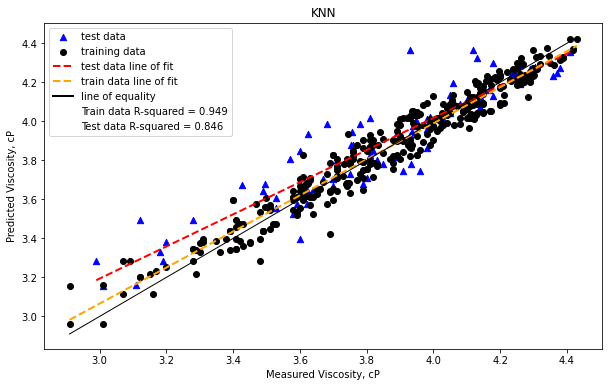

In [73]:
# Plot predicted vs Measured for Apparent Viscosity
predicted = KNN_pred_train
predicted2 = KNN_pred

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, predicted2 , c='blue', marker = "^", s = 40, label ='test data ')
ax.scatter(y_train, predicted, c= 'black', label ='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1).flatten())(np.unique(y_test)),color='red', linestyle='dashed', lw=2)
ax.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, predicted, 1).flatten())(np.unique(y_train)),color='orange', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title ('KNN')
ax.set_xlabel('Measured Viscosity, cP')
ax.set_ylabel('Predicted Viscosity, cP')

r2_train = f'Train data R-squared = {round(r2_score(y_train, predicted), 3 )}'
r2_test = f'Test data R-squared = {round(r2_score(y_test, predicted2), 3 )}'

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
line2 = Line2D([0], [0], label='train data line of fit', color='orange', linestyle='dashed', lw=2)
line3 = Line2D([0], [0], label='line of equality', color='black', linestyle='solid', lw=2)
text1 = mpatches.Patch(color='none', label=r2_train)
text2 = mpatches.Patch(color='none', label=r2_test)
handles.extend([line, line2,line3,text1, text2])

plt.legend(handles=handles)

plt.show()

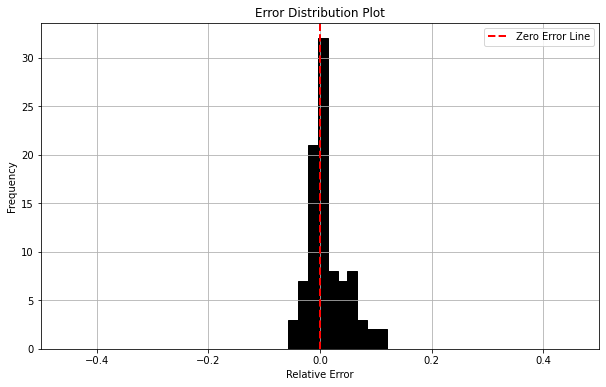

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the relative errors
relative_errors = (np.hstack(predicted2) - y_test) / y_test

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.hist(relative_errors, bins=10, edgecolor='k', color='black')
plt.title('Error Distribution Plot')
plt.xlim(-0.5, 0.5)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.grid(True)

# Add a vertical line at 0 to indicate zero error
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error Line')

# Show the legend
plt.legend()

plt.show()

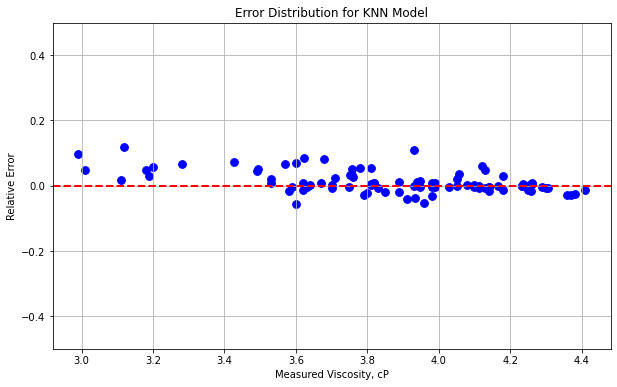

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Create the error distribution plot
relative_errors = (np.hstack(predicted2) - y_test)/ y_test  # Convert to percentage

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, relative_errors, c='blue', marker='o', s=60)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.ylim(-0.5, 0.5)
plt.title('Error Distribution for KNN Model')
plt.xlabel('Measured Viscosity, cP')
plt.ylabel('Relative Error')
plt.grid(True)

plt.show()

SVR

In [24]:
# define the base model
model = SVR()

# evaluate model
evaluate_model (model, X_train, y_train,scoring, cv)

RMSE:  0.10539109358376438 ( 0.014272630262214954 )


Fine-tune Algorithm

In [25]:
# define the base model
model = SVR() 

# define hyperparameter values
param_dist = {
    # "kernel": ['linear', 'sigmoid','poly', 'rbf', ],
    'C' : randint(1, 100),
    'gamma' : uniform(0.01,2.0),
    'kernel': ['rbf']
    #'degree' : (0.1,10),
    
    }

# Implement randomized search on hyper parameters
rnd_search = RandomizedSearchCV(estimator= model, param_distributions=param_dist,cv=cv,
                           scoring=scoring, return_train_score=True, random_state = seed,
                           verbose =2, n_jobs=-1)

# Fit to training dataset
rnd_search.fit(X_train, y_train)

rnd_search.best_params_

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


{'C': 83, 'gamma': 0.20994983163600578, 'kernel': 'rbf'}

In [26]:
# Define base model
model_SVR =rnd_search.best_estimator_

# evaluate model
evaluate_model(model_SVR, X_train, y_train, scoring, cv)

RMSE:  0.08474384833983288 ( 0.0091129046313552 )


In [27]:
modelu = SVR().fit(X_train, y_train)
# Fit the model on the training set and time the execution
fitted_SVR = model_SVR.fit(X_train, y_train)

#predict using training data
SVR_pred_train = fitted_SVR.predict(X_train)

#predict using test data
SVR_pred = fitted_SVR.predict(X_test)

# evaluate model
evaluate_model (model_SVR, X_test, y_test,scoring, cv)

RMSE:  0.12970265747654394 ( 0.03320161911303799 )


Plot Predicted vs Measured

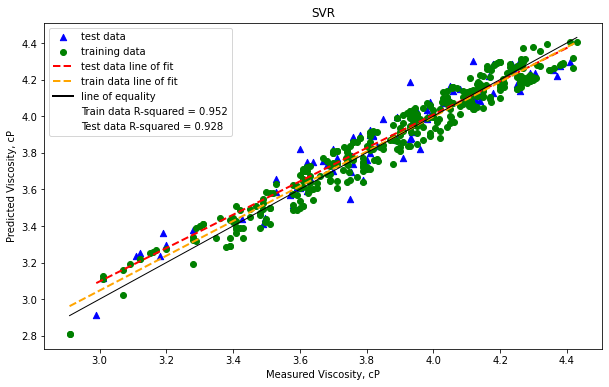

In [28]:
# Plot predicted vs Measured for Apparent Viscosity
predicted = SVR_pred_train
predicted2 = SVR_pred

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, predicted2 , c='blue', marker = "^", s = 40, label ='test data ')
ax.scatter(y_train, predicted, c= 'green', label ='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1).flatten())(np.unique(y_test)),color='red', linestyle='dashed', lw=2)
ax.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, predicted, 1).flatten())(np.unique(y_train)),color='orange', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title ('SVR')
ax.set_xlabel('Measured Viscosity, cP')
ax.set_ylabel('Predicted Viscosity, cP')

r2_train = f'Train data R-squared = {round(r2_score(y_train, predicted), 3 )}'
r2_test = f'Test data R-squared = {round(r2_score(y_test, predicted2), 3 )}'

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
line2 = Line2D([0], [0], label='train data line of fit', color='orange', linestyle='dashed', lw=2)
line3 = Line2D([0], [0], label='line of equality', color='black', linestyle='solid', lw=2)
text1 = mpatches.Patch(color='none', label=r2_train)
text2 = mpatches.Patch(color='none', label=r2_test)
handles.extend([line, line2,line3,text1, text2])

plt.legend(handles=handles)

plt.show()

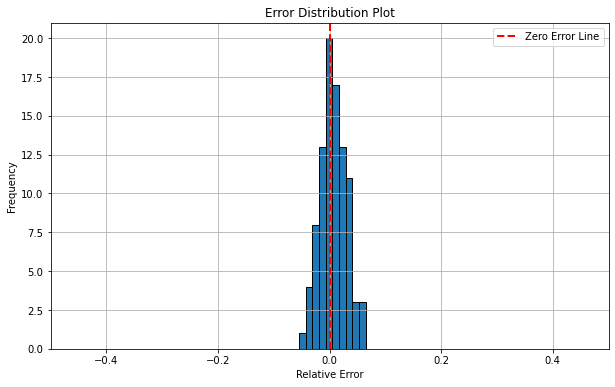

In [29]:
# Calculate the relative errors

relative_errors = (np.hstack(predicted2) - y_test) / y_test

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.hist(relative_errors, bins=10, edgecolor='k')
plt.title('Error Distribution Plot')
plt.xlim(-0.5, 0.5)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.grid(True)

# Add a vertical line at 0 to indicate zero error
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error Line')

# Show the legend
plt.legend()

plt.show()

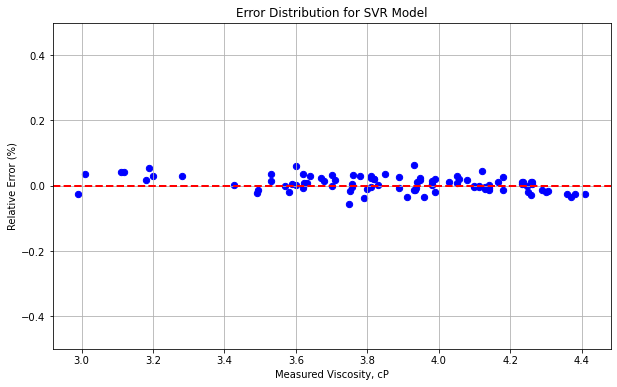

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Create the error distribution plot
relative_errors = (np.hstack(predicted2) - y_test)/ y_test  # Convert to percentage

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, relative_errors, c='blue', marker='o', s=40)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.ylim(-0.5, 0.5)
plt.title('Error Distribution for SVR Model')
plt.xlabel('Measured Viscosity, cP')
plt.ylabel('Relative Error (%)')
plt.grid(True)

plt.show()

Feature Importance

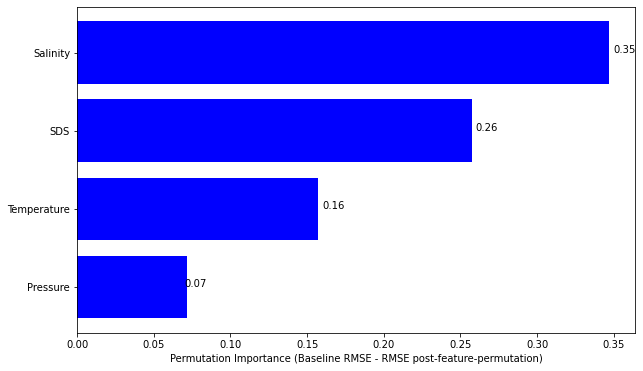

In [31]:
# perform permutation importance
results = permutation_importance(model_SVR, X_train, y_train,
                                 scoring='neg_root_mean_squared_error', 
                                 n_repeats=10, n_jobs=-1, random_state=42)
# get importance
feature_importance = results.importances_mean



sorted_feat= sorted(zip(feature_importance, train_X), reverse=False)

# Create two lists from the list of tuples created
value,name = [list(c) for c in zip(*sorted_feat)]

# Plot the features
f = plt.figure(figsize=(10,6))
plt.barh(y = name, width= value, color= 'b')

for index, value in enumerate(value):
  value = round(value,2)
  plt.text(value, index, str(value))

plt.xlabel('Permutation Importance (Baseline RMSE - RMSE post-feature-permutation)')
# plt.ylabel(' Features ')
plt.show()

Polynomial Regression

In [32]:
degree = 4
poly = PolynomialFeatures(degree=degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

# define the base model
model_PR = LinearRegression()

# evaluate model
evaluate_model(model_PR, X_train_poly, y_train,scoring, cv)

RMSE:  0.09544659436819344 ( 0.014327057122174441 )


In [33]:

# Fit the model on the training set and time the execution
fitted_PR = model_PR.fit(X_train_poly, y_train)

#predict using training data
PR_pred_train = fitted_PR.predict(X_train_poly)

#predict using test data
PR_pred = fitted_PR.predict(X_test_poly)

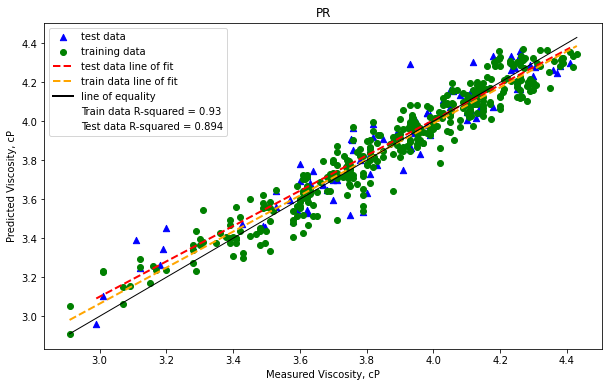

In [34]:
# Plot predicted vs Measured for Apparent Viscosity
predicted = PR_pred_train
predicted2 = PR_pred

fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(y_test, predicted2 , c='blue', marker = "^", s = 40, label ='test data ')
ax.scatter(y_train, predicted, c= 'green', label ='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1))(np.unique(y_test)),color='red', linestyle='dashed', lw=2)
ax.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, predicted, 1))(np.unique(y_train)),color='orange', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title ('PR')
ax.set_xlabel('Measured Viscosity, cP')
ax.set_ylabel('Predicted Viscosity, cP')

r2_train = f'Train data R-squared = {round(r2_score(y_train, predicted), 3 )}'
r2_test = f'Test data R-squared = {round(r2_score(y_test, predicted2), 3 )}'

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
line2 = Line2D([0], [0], label='train data line of fit', color='orange', linestyle='dashed', lw=2)
line3 = Line2D([0], [0], label='line of equality', color='black', linestyle='solid', lw=2)
text1 = mpatches.Patch(color='none', label=r2_train)
text2 = mpatches.Patch(color='none', label=r2_test)
handles.extend([line, line2,line3,text1, text2])

plt.legend(handles=handles)

plt.show()

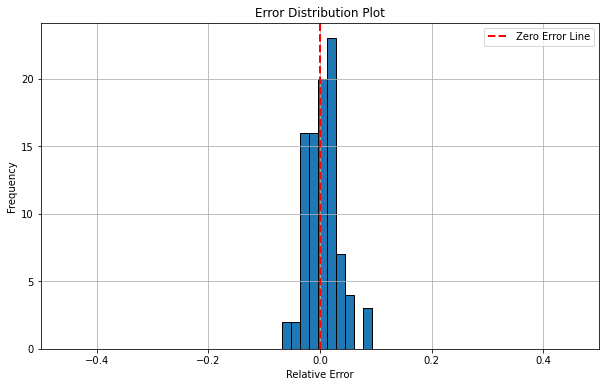

In [35]:
# Calculate the relative errors
relative_errors = (np.hstack(predicted2) - y_test) / y_test

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.hist(relative_errors, bins=10, edgecolor='k')
plt.title('Error Distribution Plot')
plt.xlim(-0.5, 0.5)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.grid(True)

# Add a vertical line at 0 to indicate zero error
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error Line')

# Show the legend
plt.legend()

plt.show()

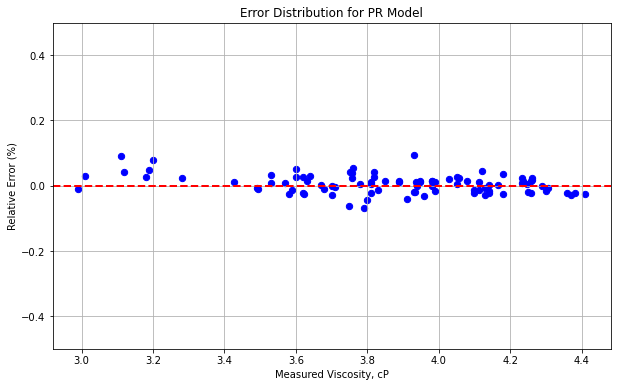

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Create the error distribution plot
relative_errors = (np.hstack(predicted2) - y_test)/ y_test  # Convert to percentage

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, relative_errors, c='blue', marker='o', s=40)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.ylim(-0.5, 0.5)
plt.title('Error Distribution for PR Model')
plt.xlabel('Measured Viscosity, cP')
plt.ylabel('Relative Error (%)')
plt.grid(True)

plt.show()

MLPNN

In [37]:
#Create function to build and compile a Keras model
from tensorflow.keras.constraints import max_norm
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, RMSprop


def build_model(n_hidden=1, n_neurons=20, learning_rate = 2e-3, input_shape = X_train.shape[1:]): # explicitly state no of features as input_shape
  model = Sequential()
  options = {"input_shape": input_shape}

  for layer in range(n_hidden):
    model.add(Dense(n_neurons, activation="relu", 

                    **options))
    options ={} # so that input_shape option only applies to first layer

  model.add(Dense(1, activation="linear",  

                  **options)) #output layer

  optimizer = RMSprop(learning_rate)
  model.compile(loss = "mse", optimizer = optimizer) # mse represents l2 loss

  return model

In [38]:
model_ANN = build_model()
fitted_ANN = model_ANN.fit(X_train, y_train,
        epochs = 300, batch_size = 20,
        validation_split = 0.2,
        callbacks=[keras.callbacks.EarlyStopping(patience=10)], verbose =0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                100       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


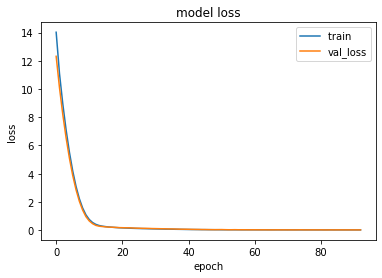

In [39]:
model_ANN.summary()
# summarize history for loss
plt.plot(fitted_ANN.history['loss'])
plt.plot(fitted_ANN.history[ 'val_loss' ])
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train ', 'val_loss' ], loc= 'upper right' )
plt.show()

In [40]:
model_ANN.evaluate(X_train,y_train)

12/12 [==============================] - 0s 1ms/step - loss: 0.0173


0.017283344641327858

In [41]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

ANN_pred_train = model_ANN.predict(X_train)
ANN_pred = model_ANN.predict(X_test)

3/3 [==============================] - 0s 1ms/step


In [42]:
print (mean_squared_error(y_train,ANN_pred_train, squared=False))
print (mean_squared_error(y_test,ANN_pred, squared=False))

0.13146613266066992
0.15686761491518225


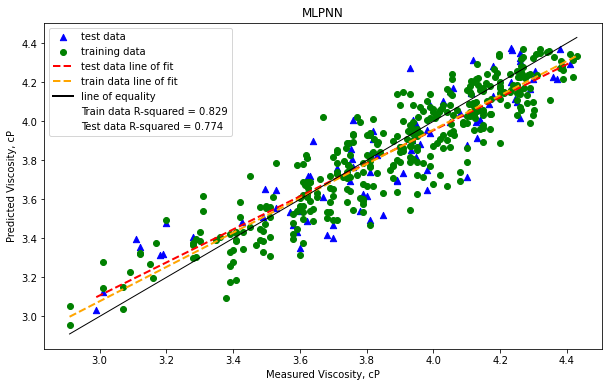

In [43]:
# Plot predicted vs Measured for Apparent Viscosity

predicted = ANN_pred_train
predicted2 = ANN_pred

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, predicted2 , c='blue', marker = "^", s = 40, label ='test data ')
ax.scatter(y_train, predicted, c= 'green', label ='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1).flatten())(np.unique(y_test)),color='red', linestyle='dashed', lw=2)
ax.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, predicted, 1).flatten())(np.unique(y_train)),color='orange', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title ('MLPNN')
ax.set_xlabel('Measured Viscosity, cP')
ax.set_ylabel('Predicted Viscosity, cP')


r2_train = f'Train data R-squared = {round(r2_score(y_train, predicted), 3 )}'
r2_test = f'Test data R-squared = {round(r2_score(y_test, predicted2), 3 )}'

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
line2 = Line2D([0], [0], label='train data line of fit', color='orange', linestyle='dashed', lw=2)
line3 = Line2D([0], [0], label='line of equality', color='black', linestyle='solid', lw=2)
text1 = mpatches.Patch(color='none', label=r2_train)
text2 = mpatches.Patch(color='none', label=r2_test)
handles.extend([line, line2,line3,text1, text2])

plt.legend(handles=handles)

plt.show()

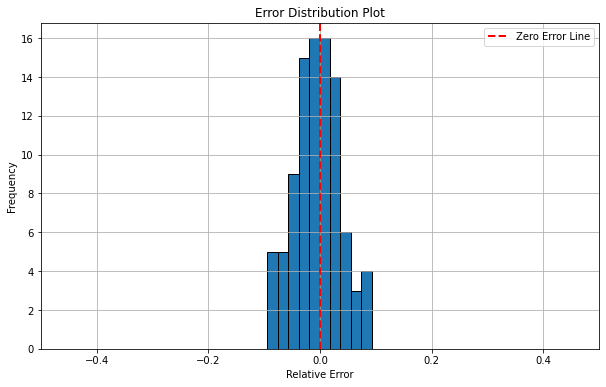

In [44]:
# Calculate the relative errors
relative_errors = (np.hstack(predicted2) - y_test) / y_test

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.hist(relative_errors, bins=10, edgecolor='k')
plt.title('Error Distribution Plot')
plt.xlim(-0.5, 0.5)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.grid(True)

# Add a vertical line at 0 to indicate zero error
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error Line')

# Show the legend
plt.legend()

plt.show()

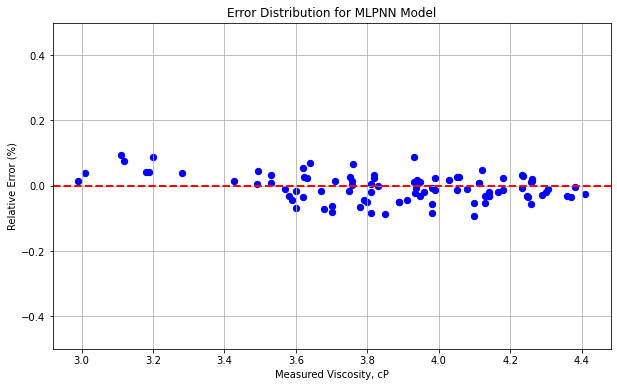

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Create the error distribution plot
relative_errors = (np.hstack(predicted2) - y_test)/ y_test  # Convert to percentage

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, relative_errors, c='blue', marker='o', s=40)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.ylim(-0.5, 0.5)
plt.title('Error Distribution for MLPNN Model')
plt.xlabel('Measured Viscosity, cP')
plt.ylabel('Relative Error (%)')
plt.grid(True)

plt.show()

CART

In [46]:
# define the base model
model = DecisionTreeRegressor()

# wrapper = MultiOutputRegressor(model)
evaluate_model(model, X_train, y_train,scoring, cv)

RMSE:  0.11014249510038482 ( 0.01983533370450469 )


Fine-tune Algorithm

In [47]:
# define the base model
model = DecisionTreeRegressor(random_state= 42,) 

param_dist = {
    "max_depth": randint(2, 20),
    "min_samples_split": randint(2, 15),
    # 'min_samples_leaf' : randint(1, 100),
    # # 'max_features' : ["auto", "sqrt", "log2"],
    # "max_leaf_nodes": randint(2, 100),
    }

rnd_search = RandomizedSearchCV(estimator= model, param_distributions=param_dist,cv=cv,
                           scoring=scoring, return_train_score=True, random_state = seed,
                           verbose =2, n_jobs=-1,)
rnd_search.fit(X_train, y_train)

rnd_search.best_params_

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


{'max_depth': 13, 'min_samples_split': 7}

In [48]:
# Define model
model_CART =rnd_search.best_estimator_

# evaluate model
evaluate_model(model_CART,X_train, y_train, scoring,cv)

RMSE:  0.11587122589947889 ( 0.01819142926332922 )


In [49]:
# Fit the model on the training set
fitted_CART = model_CART.fit(X_train, y_train)

In [50]:
CART_pred_train = fitted_CART.predict(X_train)
CART_pred = fitted_CART.predict(X_test)

In [51]:
# evaluate model
evaluate_model(model_CART,X_test, y_test, scoring,cv)

RMSE:  0.24565034899150226 ( 0.07366439311561193 )


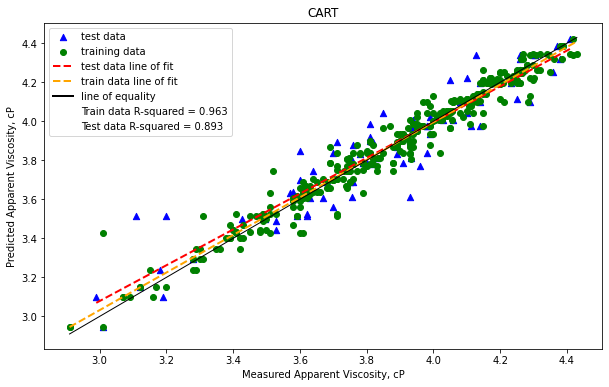

In [52]:
# Plot predicted vs Measured for Apparent Viscosity

predicted = CART_pred_train
predicted2 = CART_pred

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, predicted2 , c='blue', marker = "^", s = 40, label ='test data ')
ax.scatter(y_train, predicted, c= 'green', label ='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1).flatten())(np.unique(y_test)),color='red', linestyle='dashed', lw=2)
ax.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, predicted, 1).flatten())(np.unique(y_train)),color='orange', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title ('CART')
ax.set_xlabel('Measured Apparent Viscosity, cP')
ax.set_ylabel('Predicted Apparent Viscosity, cP')


r2_train = f'Train data R-squared = {round(r2_score(y_train, predicted), 3 )}'
r2_test = f'Test data R-squared = {round(r2_score(y_test, predicted2), 3 )}'

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
line2 = Line2D([0], [0], label='train data line of fit', color='orange', linestyle='dashed', lw=2)
line3 = Line2D([0], [0], label='line of equality', color='black', linestyle='solid', lw=2)
text1 = mpatches.Patch(color='none', label=r2_train)
text2 = mpatches.Patch(color='none', label=r2_test)
handles.extend([line, line2,line3,text1, text2])

plt.legend(handles=handles)

plt.show()

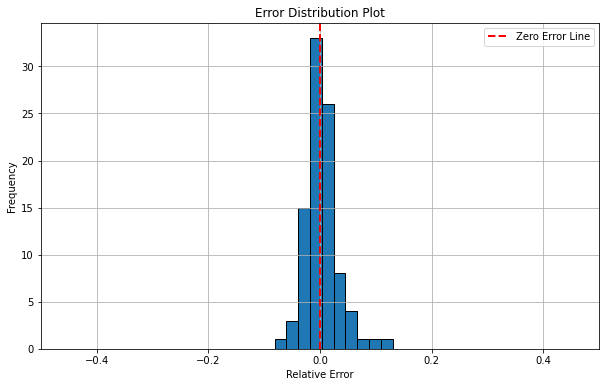

In [53]:
# Calculate the relative errors
relative_errors = (np.hstack(predicted2) - y_test) / y_test

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.hist(relative_errors, bins=10, edgecolor='k')
plt.title('Error Distribution Plot')
plt.xlim(-0.5, 0.5)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.grid(True)

# Add a vertical line at 0 to indicate zero error
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error Line')

# Show the legend
plt.legend()

plt.show()

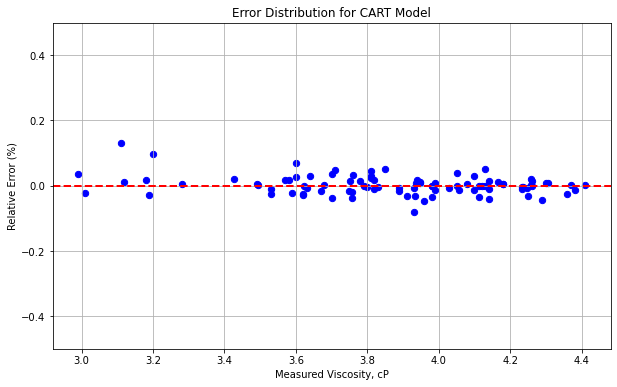

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Create the error distribution plot
relative_errors = (np.hstack(predicted2) - y_test)/ y_test  # Convert to percentage

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, relative_errors, c='blue', marker='o', s=40)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.ylim(-0.5, 0.5)
plt.title('Error Distribution for CART Model')
plt.xlabel('Measured Viscosity, cP')
plt.ylabel('Relative Error (%)')
plt.grid(True)

plt.show()

In [55]:
# Define model
model_CART =rnd_search.best_estimator_

# evaluate model
evaluate_model(model_CART,X_train, y_train, scoring,cv)

RMSE:  0.11587122589947889 ( 0.01819142926332922 )


Ensemble Methods

Super-learner

In [56]:
# create a list of base-models
def get_models():
	models = []
	models.append(('SVR', model_SVR))
	models.append(('PR', model_PR)) 
	models.append(('MLPNN', model_ANN))
	models.append(('CART', model_CART))
	models.append(('KNN', model_KNN))

	return models

# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, y, models):
	meta_X, meta_y = list(), list()
 
	# define split of data
	kfold = KFold(n_splits=10, shuffle=True)
 
	# enumerate splits
	for train_ix, test_ix in kfold.split(X):
		fold_yhats = list()
		# get data
		train_X, test_X = X[train_ix], X[test_ix] 
		train_y, test_y = y[train_ix], y[test_ix]
		meta_y.extend(test_y)
	
		# fit and make predictions with each sub-model
		for name,model in models:
			if name == 'PR':
				X_train_poly = PolynomialFeatures(degree=degree).fit_transform(train_X)
				test_X_poly = PolynomialFeatures(degree=degree).fit_transform(test_X)
		
				model.fit(X_train_poly, train_y)
				yhat = model.predict(test_X_poly)
		
			elif name == 'ANN':
				model.fit(train_X, train_y, epochs = 500, batch_size = 20, 
					validation_split = 0.2,callbacks=[keras.callbacks.EarlyStopping(patience=10)], verbose=0)
				yhat = model.predict(test_X)
		
			else:
				model.fit(train_X, train_y)
				yhat = model.predict(test_X)			

			# store columns
			fold_yhats.append(yhat.reshape(len(yhat),1))
		# store fold yhats as columns
		meta_X.append(hstack(fold_yhats))
	return vstack(meta_X), asarray(meta_y)

# fit all base models on the training dataset
def fit_base_models(X, y, models):
	
	for name,model in models:
		if name == 'PR':
			# fit in training set
			X_poly = PolynomialFeatures(degree=degree).fit_transform(X)
			model.fit(X_poly, y)
	 
		elif name == 'ANN':
			model.fit(X, y, epochs = 500, batch_size = 20, 
         validation_split = 0.2,callbacks=[keras.callbacks.EarlyStopping(patience=10)], verbose=0)
		else:
			# fit in training set
			model.fit(X, y)	

# fit a meta model
def fit_meta_model(X, y):
	model = LinearRegression()
	model.fit(X, y)
	return model

# evaluate a list of models on a dataset
def evaluate_models(X, y, models):
	for name, model in models:
		if name == 'PR':
			X_poly = PolynomialFeatures(degree=degree).fit_transform(X)
			yhat = model.predict(X_poly)
		
		else:
			yhat = model.predict(X)

		mse = mean_squared_error(y, yhat, squared=False)
		# print('%s: RMSE %.3f' % (name, (mse)))
	

# make predictions with stacked model
def super_learner_predictions(X, models, meta_model):
	meta_X = list()
	for name, model in models:
		if name == 'PR':
			X_poly = PolynomialFeatures(degree=degree).fit_transform(X)
			yhat = model.predict(X_poly)

		else:
			yhat = model.predict(X)
		
		meta_X.append(yhat.reshape(len(yhat),1))
	meta_X = hstack(meta_X)
 
	# predict
	yhat_meta = meta_model.predict(meta_X)

	return yhat_meta


X,y = X_train, y_train
X_val, y_val = X_test, y_test 

# get models
models = get_models()

# get out of fold predictions
meta_X, meta_y = get_out_of_fold_predictions(X, y, models)

# fit base models
fit_base_models(X, y, models)

# fit the meta model
meta_model = fit_meta_model(meta_X, meta_y)

# evaluate base models
evaluate_models(X_val, y_val, models)

# evaluate meta model
Super_pred = super_learner_predictions(X_val, models, meta_model)

# evaluate meta model
Super_pred_train = super_learner_predictions(X, models, meta_model)

12/12 [==============================] - 0s 907us/step


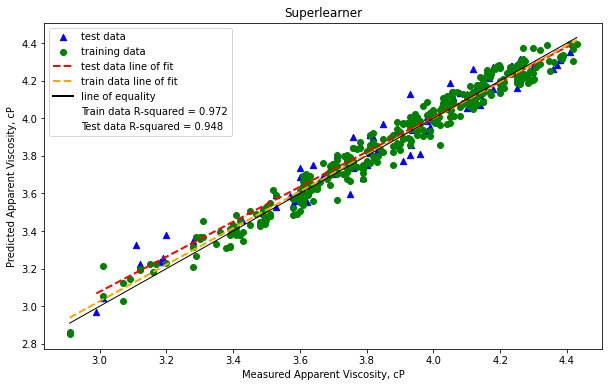

In [57]:
# Plot predicted vs Measured for Apparent Viscosity

predicted = Super_pred_train
predicted2 = Super_pred

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test, predicted2 , c='blue', marker = "^", s = 40, label ='test data ')
ax.scatter(y_train, predicted, c= 'green', label ='training data')
ax.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predicted2, 1).flatten())(np.unique(y_test)),color='red', linestyle='dashed', lw=2)
ax.plot(np.unique(y_train), np.poly1d(np.polyfit(y_train, predicted, 1).flatten())(np.unique(y_train)),color='orange', linestyle='dashed', lw=2)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='black', linestyle='-', lw=1)

ax.set_title ('Superlearner')
ax.set_xlabel('Measured Apparent Viscosity, cP')
ax.set_ylabel('Predicted Apparent Viscosity, cP')


r2_train = f'Train data R-squared = {round(r2_score(y_train, predicted), 3 )}'
r2_test = f'Test data R-squared = {round(r2_score(y_test, predicted2), 3 )}'

# Extend the legend to include the line of fit
handles, labels = plt.gca().get_legend_handles_labels()

line = Line2D([0], [0], label='test data line of fit', color='red', linestyle='dashed', lw=2)
line2 = Line2D([0], [0], label='train data line of fit', color='orange', linestyle='dashed', lw=2)
line3 = Line2D([0], [0], label='line of equality', color='black', linestyle='solid', lw=2)
text1 = mpatches.Patch(color='none', label=r2_train)
text2 = mpatches.Patch(color='none', label=r2_test)
handles.extend([line, line2,line3,text1, text2])

plt.legend(handles=handles)

plt.show()

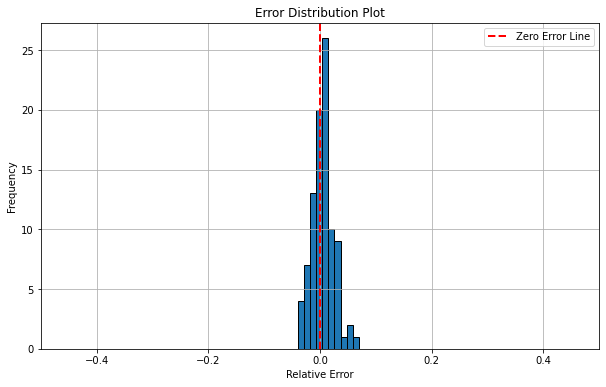

In [58]:
# Calculate the relative errors
relative_errors = (np.hstack(predicted2) - y_test) / y_test

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.hist(relative_errors, bins=10, edgecolor='k')
plt.title('Error Distribution Plot')
plt.xlim(-0.5, 0.5)
plt.xlabel('Relative Error')
plt.ylabel('Frequency')
plt.grid(True)

# Add a vertical line at 0 to indicate zero error
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error Line')

# Show the legend
plt.legend()

plt.show()

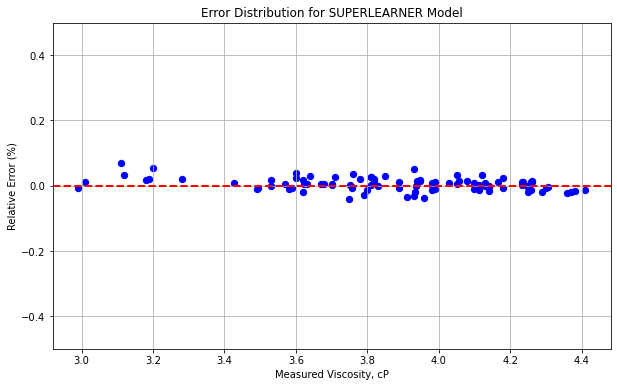

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Create the error distribution plot
relative_errors = (np.hstack(predicted2) - y_test)/ y_test  # Convert to percentage

# Create the error distribution plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, relative_errors, c='blue', marker='o', s=40)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.ylim(-0.5, 0.5)
plt.title('Error Distribution for SUPERLEARNER Model')
plt.xlabel('Measured Viscosity, cP')
plt.ylabel('Relative Error (%)')
plt.grid(True)

plt.show()

Evaluation

In [60]:
models_train =[]
models_test =[]

models_train.append(('SVR', SVR_pred_train))
models_train.append(('KNN', KNN_pred_train))
models_train.append(('CART', CART_pred_train))
models_train.append(('MLPNN', ANN_pred_train))
models_train.append(('PR', PR_pred_train))
models_train.append(('Super learner', Super_pred_train))





models_test.append(('SVR', SVR_pred))
models_test.append(('KNN', KNN_pred))
models_test.append(('CART', CART_pred))
models_test.append(('MLPNN', ANN_pred))
models_test.append(('PR', PR_pred))
models_test.append(('Super learner', Super_pred))

MSE

In [61]:
# Compare Models using MSE for train set
results = {}

# Evaluate each model in turn
for name, predict_val in models_train:
    cv_results = mean_squared_error(y_train, predict_val, squared=True)
    cv_results = round(np.abs(cv_results), 3 )
    results[name] = cv_results

mse_train = pd.DataFrame(results, index =['mse_train',] )

In [62]:
# Compare Models using MSE for test set
results = {}

# Evaluate each model in turn
for name, predict_val in models_test:
    cv_results = mean_squared_error(y_test, predict_val,squared=True)
    cv_results = round(np.abs(cv_results), 3 )
    results[name] = cv_results

mse_test = pd.DataFrame(results, index =['mse_test',] )

RMSE

In [63]:
# Compare Models using RMSE for train set
results = {}

# Evaluate each model in turn

for name, predict_val in models_train:
    cv_results = mean_squared_error(y_train, predict_val, squared=False)
    cv_results = round(np.abs(cv_results), 3 )
    results[name] = cv_results

rmse_train = pd.DataFrame(results, index =['rmse_train',] )

In [64]:
# Compare Models using MSE for test set
results = {}

# Evaluate each model in turn

for name, predict_val in models_test:
    cv_results = mean_squared_error(y_test, predict_val,squared=False)
    cv_results = round(np.abs(cv_results), 3 )
    results[name] = cv_results

rmse_test = pd.DataFrame(results, index =['rmse_test',] )

MAE

In [65]:
# Compare Models using MAE for train set
results = {}

# Evaluate each model in turn

for name, predict_val in models_train:
    cv_results = mean_absolute_error(y_train, predict_val)
    cv_results = round(np.abs(cv_results), 3 )
    results[name] = cv_results

mae_train = pd.DataFrame(results, index =['mae_train',] )

In [66]:
# Compare Models using MAE for test set

results = {}

# Evaluate each model in turn
for name, predict_val in models_test:
    cv_results = mean_absolute_error(y_test, predict_val)
    cv_results = round(np.abs(cv_results), 3 )
    results[name] = cv_results

mae_test = pd.DataFrame(results, index =['mae_test',] )

R SQUARED

In [67]:
# Compare Models using R-squared for training set
results = {}

# Evaluate each model in turn
for name, predict_val in models_train:
    cv_results = round(r2_score(y_train, predict_val), 3 )
    results[name] = cv_results

r2_train = pd.DataFrame(results, index =['r2_train',] )

In [68]:
# Compare Models using R-squared for test set
results = {}

# Evaluate each model in turn
for name, predict_val in models_test:
    cv_results = round(r2_score(y_test, predict_val), 3 )
    results[name] = cv_results

r2_test = pd.DataFrame(results, index =['r2_test',] )

In [69]:
output = pd.concat([
                    rmse_train, rmse_test, 
                    mae_train, mae_test,
                    r2_train, r2_test,] )
output

,SVR,KNN,CART,MLPNN,PR,Super learner
rmse_train,0.070,0.072,0.061,0.131,0.084,0.053
rmse_test,0.089,0.130,0.108,0.157,0.108,0.075
mae_train,0.059,0.059,0.041,0.103,0.067,0.044
mae_test,0.072,0.090,0.078,0.129,0.086,0.059
r2_train,0.952,0.949,0.963,0.829,0.930,0.972
r2_test,0.928,0.846,0.893,0.774,0.894,0.948
